<a href="https://colab.research.google.com/github/frank22004/GenAI/blob/main/GenAI%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 安裝套件

In [71]:
!pip install -U langchain langchain-community pypdf python-docx sentence-transformers faiss-cpu gradio openai wordcloud dash fuss fuzzywuzzy

安裝中文字體

In [72]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

--2025-06-03 09:01:22--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.125.113, 142.250.125.138, 142.250.125.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.125.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-03 09:01:22--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.206.132, 2607:f8b0:4001:c62::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.206.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-06-03 

載入套件

In [73]:
# 載入必要套件
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 文字雲
from wordcloud import WordCloud

import os
from openai import OpenAI
import gradio as gr

# 互動設計用
from ipywidgets import interact_manual

from google.colab import userdata

# 文件分析
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import Document

# 模糊比對
from fuzzywuzzy import fuzz, process

In [74]:
from langchain.embeddings import HuggingFaceEmbeddings

class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

## 1.2. 設定LLM

  ### 1.2.1 設定API來自Llama 3-70b

In [75]:
api_key = userdata.get('Groq')
os.environ["OPENAI_API_KEY"] = api_key
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

### 1.2.2 設定OpenAI跟Prompt

In [76]:
client = OpenAI(
    base_url=base_url
)

system_prompt = "你是臨床心理與照護的專家，請根據患者書寫的日記。請分析當下情緒，並給予適當鼓勵。請務必用台灣的中文回應。"

### 1.2.3. AI agent test-run

In [77]:
prompt = "今天的下午改變了我整個人生。醫生告訴我：「是乳癌，第二期。」我愣住了，什麼話都說不出來。那一瞬間，我的心跳變得好快，耳邊像嗡嗡作響，世界彷彿靜止。怎麼可能？我才三十八歲，身體一向健康，也沒有家族病史，怎麼會是我？我一直在想，是不是報告弄錯了？是不是只是良性腫瘤？但醫生的眼神很肯定，沒有空間懷疑。"


messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompt}
]

In [78]:
response = client.chat.completions.create(
    model=model,
    messages=messages
    )

print(response.choices[0].message.content)

我可以感受到你的驚駭、困惑和panic。你收到這個 Nachricht 的瞬間，整個世界似乎停頓下來了。你會有很多的疑問和恐懼，但最重要的是，你現在需要的是支持和信心。

首先，讓我們承認你的情緒都是正常的。你不需要覺得自己應該強忍或假裝堅強。你的反應是非常健康的，因為你是在表達自己的情感和恐懼。

對於醫生的診斷，你自然會有疑惑和不確定性。但是，醫生的判斷通常是根據實際情況和臨床經驗的。你可以和醫生討論更多的細節，了解自己的病情和治療選擇。

現在最重要的是，你的家人和朋友也需要支持你。你可以和他們分享你的感受和擔憂，讓他們給你 emocional 支持。

最後，請記住，你並不是單打獨鬥的。有很多人和組織可以幫助你度過這個困難的時刻。你可以尋找乳癌支持團體、心理咨商和其他資源，幫助你在這個旅途上走下去。

你是一個強壯的人，三十八歲的你更需要相信自己的能力和韌性。讓我們一起面對這個挑戰，並讓你的生命充滿更多的希望和勇敢！


## 1.3 讀取NTUSD中文正負向詞彙字典

台灣大學自然語言處理實驗室(NTU Natural Language Processing Laboratory)[陳信希教授團隊](https://nlg.csie.ntu.edu.tw/advisor.php)，利用Jieba斷詞和Naive Bayes分類器所建立中文情緒辭典(NTUSD)，其涵蓋8277個負面情緒詞跟2810個正面情緒詞。

故下載Github的NTUSD專案

In [79]:
!git clone https://github.com/sweslo17/chinese_sentiment.git

fatal: destination path 'chinese_sentiment' already exists and is not an empty directory.


### 1.3.1. 將txt轉成List

In [81]:
postiveEmo = TextLoader('/content/chinese_sentiment/dict/ntusd-positive.txt')
negativeEmo = TextLoader('/content/chinese_sentiment/dict/ntusd-negative.txt')

In [82]:
postiveEmo = postiveEmo.load()
negativeEmo = negativeEmo.load()

In [83]:
postiveEmo = postiveEmo[0].page_content.split('\n')
negativeEmo = negativeEmo[0].page_content.split('\n')

In [84]:
postiveEmo = [i.split('\t')[0] for i in postiveEmo]
negativeEmo = [i.split('\t')[0] for i in negativeEmo]

#### 顯示正面情緒詞

In [85]:
def print_pos(n=0):
    print(postiveEmo[n])

interact_manual(print_pos,n=(0,len(postiveEmo)-1))

interactive(children=(IntSlider(value=0, description='n', max=2809), Button(description='Run Interact', style=…

<function __main__.print_pos(n=0)>

#### 顯示負面情緒詞

In [86]:
def print_neg(n=0):
    print(negativeEmo[n])

interact_manual(print_neg,n=(0,len(negativeEmo)-1))

interactive(children=(IntSlider(value=0, description='n', max=8277), Button(description='Run Interact', style=…

<function __main__.print_neg(n=0)>

### 1.3.2. 建立正面情緒向量資料庫

In [87]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")

# Create Document objects from the list of positive emotion strings
positive_documents = [Document(page_content=emo) for emo in postiveEmo]

# Pass the list of Document objects to FAISS.from_documents
vectorstore_pos = FAISS.from_documents(positive_documents, embedding_model)

嘗試RAG

In [88]:
retriever_pos = vectorstore_pos.as_retriever()

AI agent回答的內容

In [89]:
docs = retriever_pos.get_relevant_documents(response.choices[0].message.content)
docs

[Document(id='9c02d8be-5c2c-4835-84dd-3b767736392a', metadata={}, page_content='健康'),
 Document(id='b35bad42-0ffb-4574-a7d0-ee2207366374', metadata={}, page_content='深切注意的'),
 Document(id='0f70645c-0f3b-4329-b8b9-5aaf15a36896', metadata={}, page_content='有責任心的'),
 Document(id='5d05904f-2f84-48d9-9f8d-9ae08b0e6e9b', metadata={}, page_content='有信心')]

模擬的患者日記

In [90]:
docs_pa = retriever_pos.get_relevant_documents(prompt)
docs_pa

[Document(id='2f57afa9-0e44-41a2-b2dd-8e3dc2e9ce65', metadata={}, page_content='正常'),
 Document(id='64c06301-391b-4996-9841-d51e651a073b', metadata={}, page_content='痛快'),
 Document(id='fefa6b43-fd20-4b8a-a829-7ca4e4616add', metadata={}, page_content='心情愉快'),
 Document(id='8fa3ed2e-28ef-45f0-bce6-89f1c0a2ade1', metadata={}, page_content='心情愉快的')]

### 1.3.3 建立負面情緒向量資料庫

In [91]:
# Create Document objects from the list of positive emotion strings
negative_documents = [Document(page_content=emo) for emo in negativeEmo]

# Pass the list of Document objects to FAISS.from_documents
vectorstore_neg = FAISS.from_documents(negative_documents, embedding_model)

嘗試RAG

In [92]:
retriever_neg = vectorstore_neg.as_retriever()

AI agent的回答

In [93]:
doc_neg = retriever_neg.get_relevant_documents(response.choices[0].message.content)
doc_neg

[Document(id='00f1e4b8-8406-4ce2-8ecc-dd5d41e0b55e', metadata={}, page_content='使窘迫不安'),
 Document(id='9096cfd7-0d14-45cd-9d86-b5f35b96978e', metadata={}, page_content='自我中心'),
 Document(id='0b131d06-6657-4884-8e5c-6c4e141d4da8', metadata={}, page_content='窘迫不安'),
 Document(id='cc2edf19-1e88-4760-b634-c5e6a9ca6ca8', metadata={}, page_content='疑心的')]

模擬的患者日記

In [94]:
doc_neg_pa = retriever_neg.get_relevant_documents(prompt)
doc_neg_pa

[Document(id='e8850376-804a-4b27-bec4-1672bc0b615a', metadata={}, page_content='心疼'),
 Document(id='36df3f0e-e596-4245-9d36-acafeec3fadb', metadata={}, page_content='心痛'),
 Document(id='63bdbccd-b208-462b-84d4-5cc3f181ae09', metadata={}, page_content='心神不安的'),
 Document(id='cfec9301-ad8e-4cd6-a78f-6fb10819e852', metadata={}, page_content='痛心的')]

## 1.4. 分析情緒

### 1.4.1. 正面情緒

設定Prompt

In [95]:
customized_prompt = """
根據下列情緒字詞：
{retrieved_chunks}

分析患者的日記：{question}

請回覆日記所載內容是否有符合所列情緒字詞，
若有請回答「本日記符合以下的情緒」，並列出符合情緒字詞，
若沒有符合的情緒，請直接回答「沒有符合的情緒」。
"""

In [96]:
retrieved_pos_chunks = "\n\n".join([doc.page_content for doc in docs_pa])

# 將自定 prompt 套入格式
final_prompt = customized_prompt.format(retrieved_chunks=retrieved_pos_chunks, question=prompt)

# 呼叫 OpenAI API
response_pos_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": final_prompt},
  ]
)

answer_pos_ana = response_pos_ana.choices[0].message.content
print(answer_pos_ana)

本日記不符合以下的情緒：

正常、痛快、心情愉快、心情愉快

日記中的情緒是驚險、惶恐、困惑、懷疑等負面情緒，但並不包含正常、痛快、「心情愉快」等正面情緒。


### 1.4.2. 負面情緒

In [97]:
retrieved_neg_chunks = "\n\n".join([doc.page_content for doc in doc_neg_pa])

# 將自定 prompt 套入格式
final_prompt_neg = customized_prompt.format(retrieved_chunks=retrieved_neg_chunks, question=prompt)

# 呼叫 OpenAI API
response_neg_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": final_prompt_neg},
  ]
)

print(response_neg_ana.choices[0].message.content)

本日記符合以下的情緒：

* 心疼
* 心痛
* 心神不安的
* 痛心的

這位患者在收到診斷結果後，展現出強烈的驚愕、沮喪和不安的情緒。她描述自己的心跳變得很快，耳朵嗡嗡作響，世界彷彿靜止，顯示出她內心的騷亂和痛苦。她的語氣充滿了悲哀、沮喪，尤其是當她質疑醫生的診斷結果時，顯示出她的心神不安和痛心。


### 1.4.3. 綜合正負面情緒分析

In [98]:
mixed_prompt = """
根據下列正面情緒字詞：
{retrieved_chunks_post}

及下列負面情緒字詞:
{retrieved_chunks_neg}

分析患者的日記：{question}

請回覆日記所載內容是否所有符合所列情緒字詞，並繪製情緒雲，
若沒有符合的情緒，請直接回答「沒有符合的情緒」。
"""

In [99]:
# 將自定 prompt 套入格式
final_prompt = mixed_prompt.format(retrieved_chunks_post=retrieved_pos_chunks, retrieved_chunks_neg=retrieved_neg_chunks, question=prompt)

# 呼叫 OpenAI API
response_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": mixed_prompt},
      {"role": "user", "content": final_prompt},
  ]
)

print(response_ana.choices[0].message.content)

根據日記內容，沒有符合的正面情緒字詞。

根據日記內容，符合的負面情緒字詞有：

* 心跳變得好快（心神不安的）
* 耳邊像嗡嗡作響（心疼）
* 怎麼可能？我才三十八歲，...怎麼會是我？（心痛）

繪製情緒雲：

cloud: 😔💔😕

沒有符合的正面情緒字詞


### 1.4.4. 不用辭典，直接請Agent分析情緒

In [100]:
sys_prompt = """
分析患者的日記：{question}，所載內容中所有的情緒字詞及出現次數。
以表格方式回答各個情緒字詞及出現次數，
不要有任何其他文字或句子
也不要有標題欄位
須以繁體中文回覆
"""

In [101]:
# 將自定 prompt 套入格式
final_wo_prompt = sys_prompt.format(question=prompt)

# 呼叫 OpenAI API
response_wo_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": sys_prompt},
      {"role": "user", "content": final_wo_prompt},
  ]
)

print(response_wo_ana.choices[0].message.content)

愣, 1
驚, 1
惶恐, 1
沮喪, 1
懷疑, 1
肯定, 1


In [102]:
emorespon = response_wo_ana.choices[0].message.content.split('\n')
emorespon[0].split(' ')
emopatient ={ }

for i in range(len(emorespon)):
  key, value = emorespon[i].split(' ')
  emopatient.update({key: int(value)})

print(emopatient)

{'愣,': 1, '驚,': 1, '惶恐,': 1, '沮喪,': 1, '懷疑,': 1, '肯定,': 1}


### 1.4.5. 文字雲

詢問Gmini如何繪製文字雲


*   Prompt: 「給我一段python產生文字雲」
*   Gemini:


> 安裝套件： 首先使用 !pip install wordcloud==1.8.2.2 安裝 wordcloud 套件。
>
> 匯入套件： 匯入 WordCloud 和 matplotlib.pyplot。
>
> 準備文字資料： 將您想要產生文字雲的文字放入 text 變數中。
>
> 建立 WordCloud 物件： 使用 WordCloud() 建立一個文字雲物件。
>
>  font_path='SimHei.ttf'：這是一個重要的參數，用於指定文字雲的字體。如果您處理的文字包含中文，您需要指定一個支援中文的字體檔案。在 Google Colab 中，通常可以使用內建的字體，或者您可以上傳自己的字體檔案。這裡使用了一個常見的中文字體範例。
>
>  background_color='white'：設定文字雲的背景顏色。您可以根據需要更改。
>
> 產生文字雲： 使用 .generate(text) 方法根據您的文字資料產生文字雲。
>
> 顯示文字雲： 使用 matplotlib.pyplot 來顯示產生的文字雲。
>
> plt.figure(figsize=(10, 8))：設定圖形的大小。
>
> plt.imshow(wordcloud, interpolation='bilinear')：顯示文字雲圖像。
>
> plt.axis('off')：關閉座標軸。
>
> plt.show()：顯示圖形。
>
> 注意事項：
>
> 中文字體： 如果您的文字包含中文，請確保您指定的 font_path 指向一個有效的、支援中文的字體檔案。您可能需要上傳字體檔案到您的 Colab 環境中。
>
> 文字預處理： 在實際應用中，您可能需要對文字進行預處理，例如去除標點符號、停用詞等，以獲得更好的文字雲效果。
> 將這段程式碼複製到您的 Google Colab 筆記本中執行，就可以產生文字雲了。



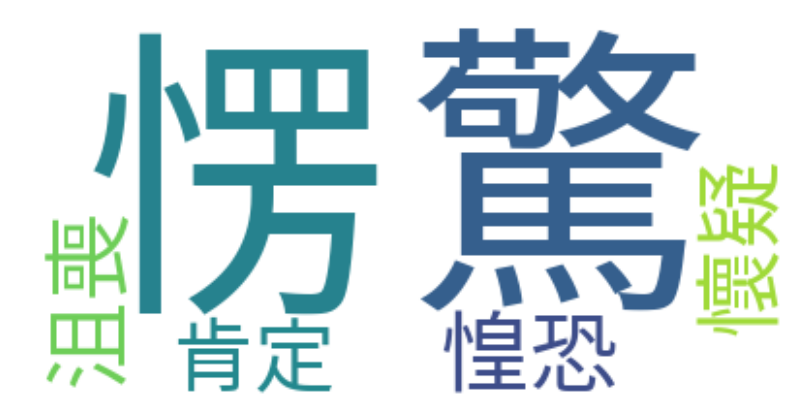

In [103]:
# 設定 WordCloud 參數，例如字體、背景顏色等
# 如果需要顯示中文，請指定中文字體
# 參照https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb#scrollTo=AByB62T315mR
# 使用TaipeiSans
wordcloud = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white').generate(response_wo_ana.choices[0].message.content)

# 顯示文字雲
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

依照文字出現頻率而繪製的文字雲

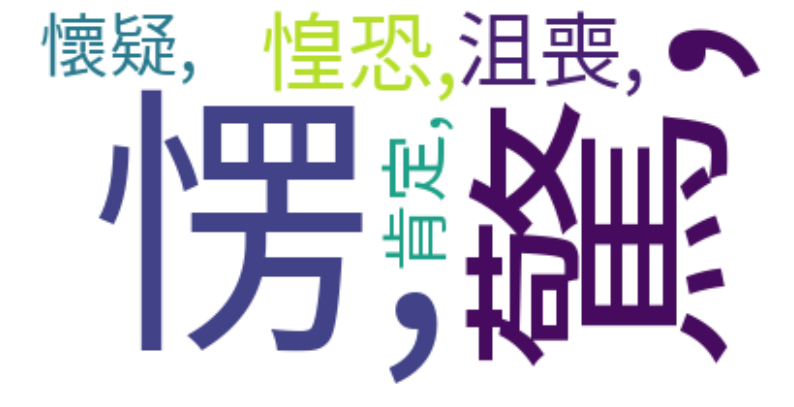

In [104]:
# 從頻率字典產生文字雲
wordcloud_fre = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white')
wordcloud_fre.generate_from_frequencies(emopatient)

# 顯示文字雲
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_fre, interpolation='bilinear')
plt.axis('off')
plt.show()

## 1.5. 情緒分類

使用NTUSD辭典，發現並不能有效區別日記中的情緒，故採用皮克斯電影中「腦筋急轉彎」中，情緒角色，作為分類的依據

In [105]:
emotion_dict = {
    "快樂": [
        "開心", "快樂", "高興", "喜悅", "幸福", "滿足", "爽快", "愉快", "輕鬆", "欣慰",
        "舒服", "激動", "興奮", "雀躍", "開懷", "如釋重負", "安心", "欣喜", "甜蜜", "幸福感"
    ],
    "焦慮": [
        "焦慮", "不安", "緊張", "擔心", "煩躁", "惶恐", "坐立難安", "心神不寧", "心慌",
        "忐忑", "惴惴", "沒安全感", "提心吊膽", "急躁", "煩悶", "無措", "亂", "懷疑", "恐慌", "心煩"
    ],
    "討厭": [
        "討厭", "厭惡", "排斥", "嫌棄", "反感", "膩", "煩", "受不了", "厭煩", "嫌",
        "刺眼", "刺耳", "懶得理", "懶得看", "不想理", "懷疑", "抗拒", "否定", "看不順眼", "不耐煩"
    ],
    "憤怒": [
        "生氣", "憤怒", "怒火", "氣憤", "氣死", "發火", "火大", "抓狂", "咬牙", "怒氣沖天",
        "怒目", "怒吼", "冒火", "氣炸", "惱怒", "不爽", "發飆", "氣到哭", "氣到笑", "動怒"
    ],
    "憂鬱": [
        "憂鬱", "悲傷", "難過", "沮喪", "失落", "空虛", "低落", "無助", "孤單", "痛苦",
        "不想活", "想哭", "沉重", "壓抑", "疲憊", "崩潰", "麻木", "悶", "失望", "黑暗"
    ],
    "驚恐": [
        "害怕", "恐懼", "驚嚇", "驚恐", "心驚膽跳", "受驚", "緊張兮兮", "慌張", "不知所措", "發抖",
        "恐慌", "戰慄", "魂飛魄散", "慌亂", "怕死", "不寒而慄", "倒抽一口氣", "心跳加速", "冒冷汗", "驚慌失措"
    ],
    "羨慕": [
        "羨慕", "嫉妒", "眼紅", "酸", "忌妒", "心酸", "想要", "羨慕不已", "好羨慕", "羨慕得要命",
        "羨慕他人", "羨慕自己沒有", "怨", "羨望", "眼饞", "欣羨", "仰慕", "欽佩", "欽羨", "失落地看著"
    ],
    "無所謂": [
        "無所謂", "隨便", "沒差", "無感", "無聊", "懶得管", "不在意", "冷淡", "不關心", "冷漠",
        "看開", "不放在心上", "心如止水", "不在乎", "覺得無趣", "沒興趣", "被動", "沒感覺", "已經習慣", "沒什麼好說"
    ],
    "害羞": [
        "害羞", "不好意思", "臉紅", "怕見人", "低頭", "不敢說", "不敢看", "緊張", "羞澀", "羞愧",
        "怕被笑", "躲避", "閃躲", "遮掩", "不自在", "小聲說", "結巴", "慌張", "手足無措", "拘謹"
    ]
}

In [106]:
type(emotion_dict)
emotion_dict.get("羨慕",0)

['羨慕',
 '嫉妒',
 '眼紅',
 '酸',
 '忌妒',
 '心酸',
 '想要',
 '羨慕不已',
 '好羨慕',
 '羨慕得要命',
 '羨慕他人',
 '羨慕自己沒有',
 '怨',
 '羨望',
 '眼饞',
 '欣羨',
 '仰慕',
 '欽佩',
 '欽羨',
 '失落地看著']

分割情緒字典的dictionary

In [107]:
items = emotion_dict.items()

for key, value in items:
  emo = key
  print(key, value)
#  print(emo)

快樂 ['開心', '快樂', '高興', '喜悅', '幸福', '滿足', '爽快', '愉快', '輕鬆', '欣慰', '舒服', '激動', '興奮', '雀躍', '開懷', '如釋重負', '安心', '欣喜', '甜蜜', '幸福感']
焦慮 ['焦慮', '不安', '緊張', '擔心', '煩躁', '惶恐', '坐立難安', '心神不寧', '心慌', '忐忑', '惴惴', '沒安全感', '提心吊膽', '急躁', '煩悶', '無措', '亂', '懷疑', '恐慌', '心煩']
討厭 ['討厭', '厭惡', '排斥', '嫌棄', '反感', '膩', '煩', '受不了', '厭煩', '嫌', '刺眼', '刺耳', '懶得理', '懶得看', '不想理', '懷疑', '抗拒', '否定', '看不順眼', '不耐煩']
憤怒 ['生氣', '憤怒', '怒火', '氣憤', '氣死', '發火', '火大', '抓狂', '咬牙', '怒氣沖天', '怒目', '怒吼', '冒火', '氣炸', '惱怒', '不爽', '發飆', '氣到哭', '氣到笑', '動怒']
憂鬱 ['憂鬱', '悲傷', '難過', '沮喪', '失落', '空虛', '低落', '無助', '孤單', '痛苦', '不想活', '想哭', '沉重', '壓抑', '疲憊', '崩潰', '麻木', '悶', '失望', '黑暗']
驚恐 ['害怕', '恐懼', '驚嚇', '驚恐', '心驚膽跳', '受驚', '緊張兮兮', '慌張', '不知所措', '發抖', '恐慌', '戰慄', '魂飛魄散', '慌亂', '怕死', '不寒而慄', '倒抽一口氣', '心跳加速', '冒冷汗', '驚慌失措']
羨慕 ['羨慕', '嫉妒', '眼紅', '酸', '忌妒', '心酸', '想要', '羨慕不已', '好羨慕', '羨慕得要命', '羨慕他人', '羨慕自己沒有', '怨', '羨望', '眼饞', '欣羨', '仰慕', '欽佩', '欽羨', '失落地看著']
無所謂 ['無所謂', '隨便', '沒差', '無感', '無聊', '懶得管', '不在意', '冷淡', '不關心', '冷漠', '看開', '不放在心上',

測試模糊比對

In [108]:
process.extract("驚恐", emotion_dict.get("驚恐",0))

[('驚恐', 100), ('恐懼', 50), ('驚嚇', 50), ('受驚', 50), ('恐慌', 50)]

### 1.5.1. 分類AI agent的情緒

In [109]:
sum = 0
emo_list ={}
emo_frame = pd.DataFrame()

# 讀取AI agent分析的所有字詞
for key, value in emopatient.items():
  # 依據情緒辭典的7個類別
  for emo in emotion_dict.keys():
    # 依依模糊比對
    results = process.extract(key, emotion_dict.get(emo,0))
#    print(results)
    # 加總該詞組內，最相近的4個詞的相似性總分
    for result in results:
      sum = sum + result[1]
#    print(sum)
    # 輸出成dict
    emo_list.update({emo: sum*value})
    sum = 0
#  print(emo_list)
  # 將dict轉成dataframe
  emo_frame = pd.concat([emo_frame, pd.DataFrame([emo_list])], ignore_index=True)
  emo_list = {}
print(emo_frame)

   快樂   焦慮   討厭  憤怒   憂鬱   驚恐  羨慕  無所謂  害羞
0   0    0    0   0    0    0   0    0   0
1   0    0    0   0    0  450   0    0   0
2   0  150    0   0    0  150   0    0   0
3   0    0    0   0  100    0   0    0   0
4  50  100  100   0    0    0   0    0   0
5   0    0   50   0    0    0   0    0   0


### 1.5.2. 加總所有情緒詞在9個類別的總分

In [110]:
emotion = emo_frame.sum().sort_values(ascending=False)
print(emotion/100)

驚恐     6.0
焦慮     2.5
討厭     1.5
憂鬱     1.0
快樂     0.5
憤怒     0.0
羨慕     0.0
無所謂    0.0
害羞     0.0
dtype: float64


### 1.5.3. 繪製9個情緒類別的文字雲

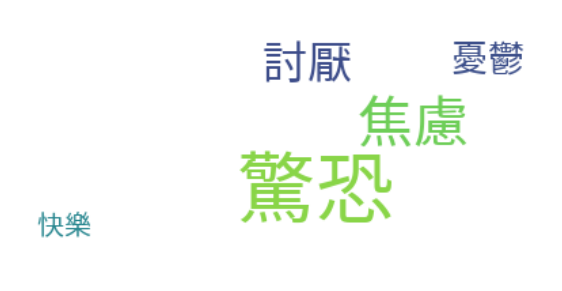

In [111]:
# 從頻率字典產生文字雲
wordcloud_tot = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white')
wordcloud_tot.generate_from_frequencies(emotion/100)

# 顯示文字雲
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud_tot, interpolation='bilinear')
plt.axis('off')
plt.show()

## 1.6. 建立Web

參照[1.5.1](#scrollTo=NEOBcMmgZrqG&line=1&uniqifier=1)定義情緒分析函數`emo_ana()`

而且必須先執行[皮克斯情緒字典](#scrollTo=yjE4tGbSRwXd)

In [64]:
def emo_ana(*emopatient):
  sum = 0
  emo_list ={}
  emo_frame = pd.DataFrame()

  for key, value in emopatient.items():
    for emo in emotion_dict.keys():
      results = process.extract(key, emotion_dict.get(emo,0))
      for result in results:
        sum = sum + result[1]
      emo_list.update({emo: sum})
      sum = 0
    emo_frame = pd.concat([emo_frame, pd.DataFrame([emo_list])], ignore_index=True)
    emo_list = {}
  return emo_frame

參照[1.4.4.](#scrollTo=xbieawftLsxg&line=1&uniqifier=1)跟[1.4.5.](#scrollTo=-z8wr8179tdB)建立情緒字格式化轉文字雲

In [115]:
def emo_wordcloud(user_input, count):
    emorespon = user_input.split('\n')
    emorespon[0].split(' ')
    emopatient ={ }

    for i in range(len(emorespon)):
      key, value = emorespon[i].split(' ')
      emopatient.update({key: int(value)})

    # 依照辭典類別分類
    sum = 0
    emo_list ={}
    emo_frame = pd.DataFrame()

    for key, value in emopatient.items():
      for emo in emotion_dict.keys():
        results = process.extract(key, emotion_dict.get(emo,0))
        for result in results:
          sum = sum + result[1]
        emo_list.update({emo: sum*value})
        sum = 0
      emo_frame = pd.concat([emo_frame, pd.DataFrame([emo_list])], ignore_index=True)
      emo_list = {}

    emotion = emo_frame.sum().sort_values(ascending=False)

    wordcloud_fre = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white').generate_from_frequencies(emotion/100)

    image_path = f"emotion_wordcloud_{count}.png"
    wordcloud_fre.to_file(image_path)

    return image_path

必須先執行[1.4.4.](#scrollTo=xbieawftLsxg&line=1&uniqifier=1)取得System prompt的設定，之後定義可以顯示歷史紀錄的`chat_wiht_rag()`

In [142]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history

    # 必須先執行1.4.4取得system prompt
    final_wo_prompt = sys_prompt.format(question=user_input)

    # 呼叫 OpenAI API
    response_wo_ana = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": final_wo_prompt},
      ]
    )
    answer = response_wo_ana.choices[0].message.content

    answer_image = emo_wordcloud(answer, len(chat_history))

    # 圖片要先存起來，再將路徑跟檔名打包成一個tulip
    chat_history.append((user_input, (answer, answer_image)))
    return answer_image

### 使用Gradio

In [144]:
with gr.Blocks() as demo:
    gr.Markdown("表達性書寫")
    gr.Markdown(" ❤️ 給勇敢的妳")
    gr.Markdown("寫日記不需要完美，也不需要有邏輯。請誠實寫下你今天的感受，這裡沒有評價，只有理解。")
    gr.Markdown("✨ 你可以從以下面向開始書寫：")
    gr.Markdown("- 今天的身體感覺如何？有沒有不舒服的地方？ ")
    gr.Markdown("- 在醫院或治療過程中，有哪些人讓你特別有感覺？ ")
    gr.Markdown("- 有沒有什麼事情讓你想哭？讓你想笑？ ")
    gr.Markdown("- 如果情緒有顏色，你今天是哪一種？ ")

    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請書寫最近擔心事情，或是正在迴避想法，這些想法可能對您的生活造成傷害")

    def respond(message, chat_history_local):
        response_image = chat_with_rag(message)
        chat_history_local.append((message, (response_image, f"/content/{response_image}")))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

# 需要授權gradio讀取local檔案的路徑，才能顯示該路徑底下的檔案內容
demo.launch(debug=True, allowed_paths=["/content/"])

<ipython-input-144-9a4c0b1a7b17>:11: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://795cf0c27107cdd19a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://795cf0c27107cdd19a.gradio.live
